Training images shape: (50000, 32, 32, 3)
Training labels shape: (50000,)
Test images shape: (10000, 32, 32, 3)
Test labels shape: (10000,)
Display the first image in the training dataset:


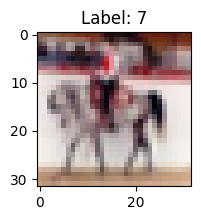

One-hot encoded training labels shape: (50000, 10)
One-hot encoded test labels shape: (10000, 10)
Training images shape: (50000, 32, 32, 3)
Training images min value: 0.0
Training images max value: 1.0
Test images shape: (10000, 32, 32, 3)
Test images min value: 0.0
Test images max value: 1.0


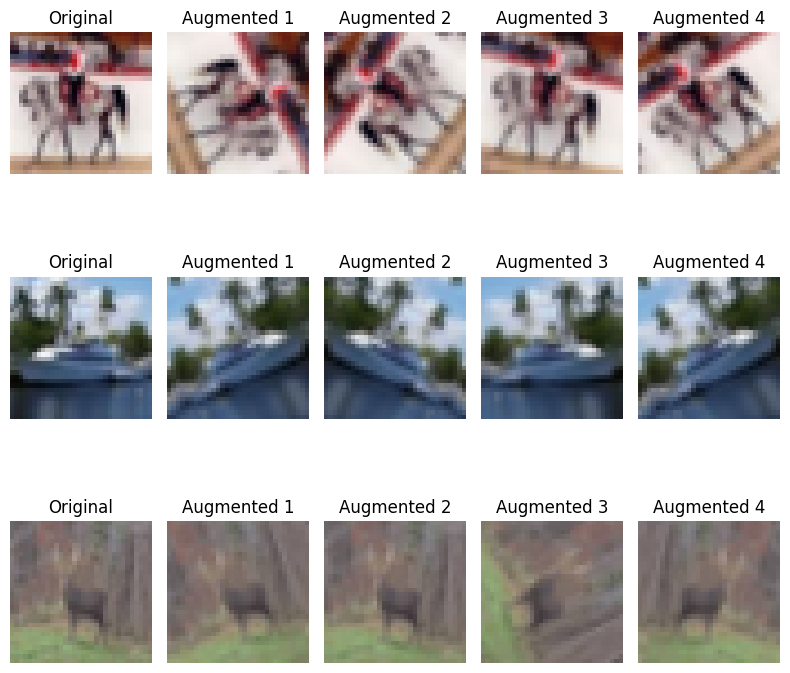

KeyboardInterrupt: 

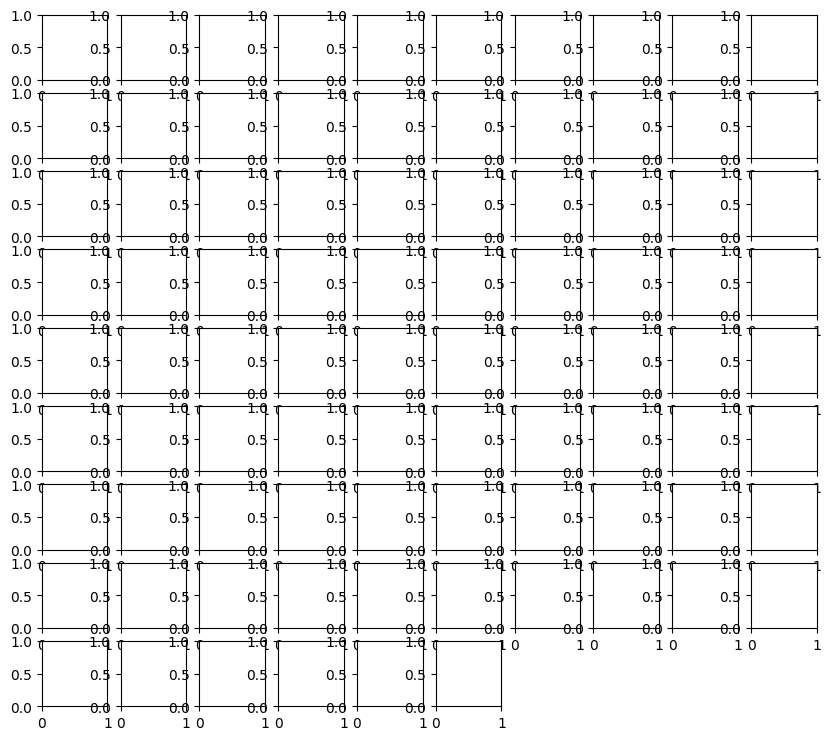

In [2]:
0.# Install TensorFlow Datasets if not already installed
!pip install tensorflow-datasets

# Import required libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
import time
import copy

# Load and convert the CIFAR-10 dataset to NumPy arrays

# Load the entire dataset at once by setting batch_size=-1
dataset, info = tfds.load('cifar10', with_info=True, batch_size=-1, as_supervised=True)

# Convert the dataset to NumPy arrays
(img_train, label_train), (img_test, label_test) = tfds.as_numpy((dataset['train'], dataset['test']))

# Check the shapes of the arrays to verify the data
print(f"Training images shape: {img_train.shape}")
print(f"Training labels shape: {label_train.shape}")
print(f"Test images shape: {img_test.shape}")
print(f"Test labels shape: {label_test.shape}")

# Define the class labels
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# Display the first image in the training dataset
print(f"Display the first image in the training dataset:")

plt.figure(figsize=(2, 2))
plt.imshow(img_train[0])
plt.title(f"Label: {labels[label_train[0]]}")
plt.show()


# 1. Data Preprocessing

# Create one-hot encoded labels
label_train_onehot = to_categorical(label_train, num_classes=10)
label_test_onehot = to_categorical(label_test, num_classes=10)

# Check the shape of the new labels
print(f"One-hot encoded training labels shape: {label_train_onehot.shape}")
print(f"One-hot encoded test labels shape: {label_test_onehot.shape}")

# Normalize the image data
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0

# Verify the normalization
print(f"Training images shape: {img_train.shape}")
print(f"Training images min value: {img_train.min()}")
print(f"Training images max value: {img_train.max()}")
print(f"Test images shape: {img_test.shape}")
print(f"Test images min value: {img_test.min()}")
print(f"Test images max value: {img_test.max()}")

# Define the data augmentation model
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

# Create a custom data generator
def augment_data(images, labels, batch_size):
    """
      This function creates a TensorFlow dataset from the input images and labels,
      applies data augmentation, and prepares it for efficient training.

      Args:
        images: Input training images in NumPy array format.
        labels: Corresponding labels for the images.
        batch_size: Number of images to be included in each training batch.

      Returns:
        A tf.data.Dataset object that contains the augmented data with shuffling, batching, and prefetching for efficient training.
    """
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y),
                          num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.prefetch(tf.data.AUTOTUNE)

# Apply data augmentation to some images and visualize the results
fig, axes = plt.subplots(3, 5, figsize=(8, 8))
for i in range(3):
    orig_image = img_train[i]
    axes[i, 0].imshow(orig_image)
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    for j in range(1, 5):
        augmented_image = data_augmentation(tf.expand_dims(orig_image, 0))
        axes[i, j].imshow(augmented_image[0])
        axes[i, j].set_title(f'Augmented {j}')
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()

# Create visualisations of some images and labels
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
classes = np.unique(label_train)
for i, cls in enumerate(classes):
    idxs = np.where(label_train == cls)[0]
    random_idxs = np.random.choice(idxs, 10, replace=False)
    for j, idx in enumerate(random_idxs):
        axes[i, j].imshow(img_train[idx])
        axes[i, j].axis('off')
    fig.text(0.08, 0.85 - (i * 0.085), f"Class: {labels[cls]}", va='center', ha='left', fontsize=8)
plt.show()


# 2. Model Architecture

model = Sequential([

# First block
Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
BatchNormalization(),
Conv2D(128, (3, 3), activation='relu', padding='same'),
BatchNormalization(),
MaxPooling2D((2, 2)),
Dropout(0.2),

# Second block
Conv2D(128, (3, 3), activation='relu', padding='same'),
BatchNormalization(),
Conv2D(128, (3, 3), activation='relu', padding='same'),
BatchNormalization(),
MaxPooling2D((2, 2)),
Dropout(0.3),

# Third block
Conv2D(256, (3, 3), activation='relu', padding='same'),
BatchNormalization(),
Conv2D(256, (3, 3), activation='relu', padding='same'),
BatchNormalization(),
MaxPooling2D((2, 2)),
Dropout(0.4),

# Fourth block
Conv2D(512, (3, 3), activation='relu', padding='same'),
BatchNormalization(),
Conv2D(512, (3, 3), activation='relu', padding='same'),
BatchNormalization(),
MaxPooling2D((2, 2)),
Dropout(0.5),

# Fifth block
Conv2D(512, (3, 3), activation='relu', padding='same'),
BatchNormalization(),
Conv2D(512, (3, 3), activation='relu', padding='same'),
BatchNormalization(),
MaxPooling2D((2, 2)),
Dropout(0.5),

(Flatten()),

Dense(128, activation='relu'),
BatchNormalization(),
Dropout(0.5),
Dense(10, activation='softmax')
])

model.summary()

# 3. Model Training

# Implement a learning rate schedule to adjust during training
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile the model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Split the data into training and validation sets
validation_split = 0.1
num_val = int(len(img_train) * validation_split)
train_images, val_images = img_train[:-num_val], img_train[-num_val:]
train_labels, val_labels = label_train_onehot[:-num_val], label_train_onehot[-num_val:]

# Create train dataset with augmentation
train_dataset = augment_data(train_images, train_labels, batch_size=64)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(64)

# Train the model
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

# 5. Transfer Learning

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data augmentation and normalization for training
# Just normalization for validation
transform_train = transforms.Compose([
    transforms.Resize(224),  # ResNet expects 224x224 images
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

# Load pre-trained ResNet18 model
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')

# Freeze all the parameters in the network
for param in model_conv.parameters():
    param.requires_grad = False

# Replace the last fully-connected layer
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10)  # 10 classes for CIFAR-10

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    """
      Train a PyTorch model and return the best performing model.

      This function trains the given model for a specified number of epochs,
      using the provided criterion, optimizer, and learning rate scheduler.
      It performs both training and validation for each epoch and keeps track
      of the best performing model based on validation accuracy.

      Args:
        model: The neural network model to train.
        criterion: Loss function to evaluate model performance.
        optimizer: Optimization algorithm to adjust model weights based on loss.
        scheduler: Learning rate scheduler to adjust the learning rate during training.
        num_epochs: Number of epochs to train the model (default: 25).

      Returns:
        The trained model with the best weights saved during validation.
    """
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = trainloader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = testloader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# 4. Models Evaluation

# 4.A Evaluate the custom CNN model

# Display training metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['Custom-CNN accuracy'])
plt.plot(history.history['Custom-CNN val_accuracy'])
plt.title('Custom-CNN Model accuracy')
plt.ylabel('Custom-CNN Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train (CNN-Model 1)', 'Validation (CNN-Model 1)'], loc='upper left')

# Get the true labels
gt = np.argmax(label_test_onehot, axis=1)
gt_labels = [labels[i] for i in gt]

# Predict the output for the test split
predictions = model.predict(img_test)
predictions = np.argmax(predictions, axis=1)
predicted_labels = [labels[i] for i in predicted_indices] 

# Calculate and print the metrics
accuracy = accuracy_score(gt_labels, predicted_labels)
precision = precision_score(gt_labels, predicted_labels, average='weighted')
recall = recall_score(gt_labels, predicted_labels, average='weighted')
f1 = f1_score(gt_labels, predicted_labels, average='weighted')

print(f"Custom-CNN Model accuracy: {accuracy:.4f}")
print(f"Custom-CNN Model precision: {precision:.4f}")
print(f"Custom-CNN Model recall: {recall:.4f}")
print(f"Custom-CNN Model F1 score: {f1:.4f}")

print(f"Predictions shape: {predictions.shape}")

# Calculate accuracy score
accuracy = accuracy_score(gt_labels, predicted_labels)
print(f"Custom-CNN Test accuracy: {accuracy:.4f}")

# Create a confusion matrix
cm = confusion_matrix(gt_labels, predicted_labels, labels=labels)


# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Custom-CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

 # Train and evaluate the pre-trained ResNet18 model
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

# Test the model
model_conv.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model_conv(images)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Calculate the ResNet18 metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f'Accuracy of the pre-trained ResNet18 network on the 10000 test images: {100 * accuracy:.2f} %')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Create and plot confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix of the pre-trained ResNet18')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

